# Objective

From the given dataset, identify the primary factors dominating the cost of the premium for the insurance of the individual. Identify critical insights which can help in designing tailor made proposals and incentivise individuals who are health concious and have lower probability of placing claims. Train a model to predict the insurance premiums for an individual given the features of the individual used for training the model. Make recommendations based on the analysis done on the dataset to ensure the insurance company is able to strike the optimum trade off between premium amount and probability of a claim.

# Library Imports and Data Ingestion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.weightstats import ztest 
from scipy.stats import ttest_ind, kruskal,shapiro, chi2_contingency
import scipy.stats as stats1

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import pickle

In [2]:
raw_ins_df = pd.read_csv('insurance.csv')

# Preliminary Data Quality observations

In [3]:
raw_ins_df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [4]:
raw_ins_df.shape

(986, 11)

In [5]:
raw_ins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


Dataset has 986 rows and 11 features. There are no null values. Even though all columns are showing up as numerical, Age, Height, Weight and PremiumPrice columns are continuous numerical columns whereas others are categorical columns.

# Outlier Verification and Treatment

In [6]:
raw_ins_df[['Age','Height','Weight','PremiumPrice']].describe()

,Age,Height,Weight,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000
mean,41.745436,168.182556,76.950304,24336.713996
std,13.963371,10.098155,14.265096,6248.184382
min,18.000000,145.000000,51.000000,15000.000000
25%,30.000000,161.000000,67.000000,21000.000000
50%,42.000000,168.000000,75.000000,23000.000000
75%,53.000000,176.000000,87.000000,28000.000000
max,66.000000,188.000000,132.000000,40000.000000


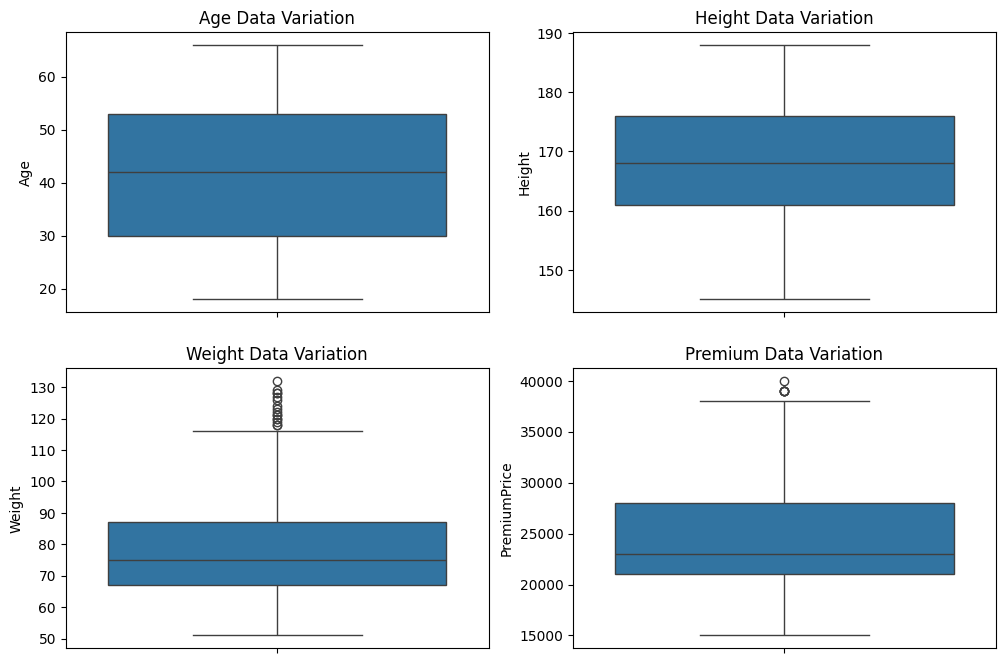

In [7]:
fig, axes=plt.subplots(2, 2, figsize=(12, 8))

def plot_data_variations(data, y_var, coordinate, title):
    sns.boxplot(data=data, y=y_var, ax=coordinate)
    coordinate.set_title(title)
plot_data_variations(raw_ins_df,'Age',axes[0,0],'Age Data Variation')
plot_data_variations(raw_ins_df,'Height',axes[0,1],'Height Data Variation')
plot_data_variations(raw_ins_df,'Weight',axes[1,0],'Weight Data Variation')
plot_data_variations(raw_ins_df,'PremiumPrice',axes[1,1],'Premium Data Variation')
plt.show()

Weight and premium price has a few outliers and others are clean. As premium price is the target column it is better not disturb the column data. Weight is having quite a few outliers but they are not so far away from the upper limit. So it will not cause a huge impact. Also manipulating weight data might lead to altered perception on the health condition of the individual and may lead to improper model training.

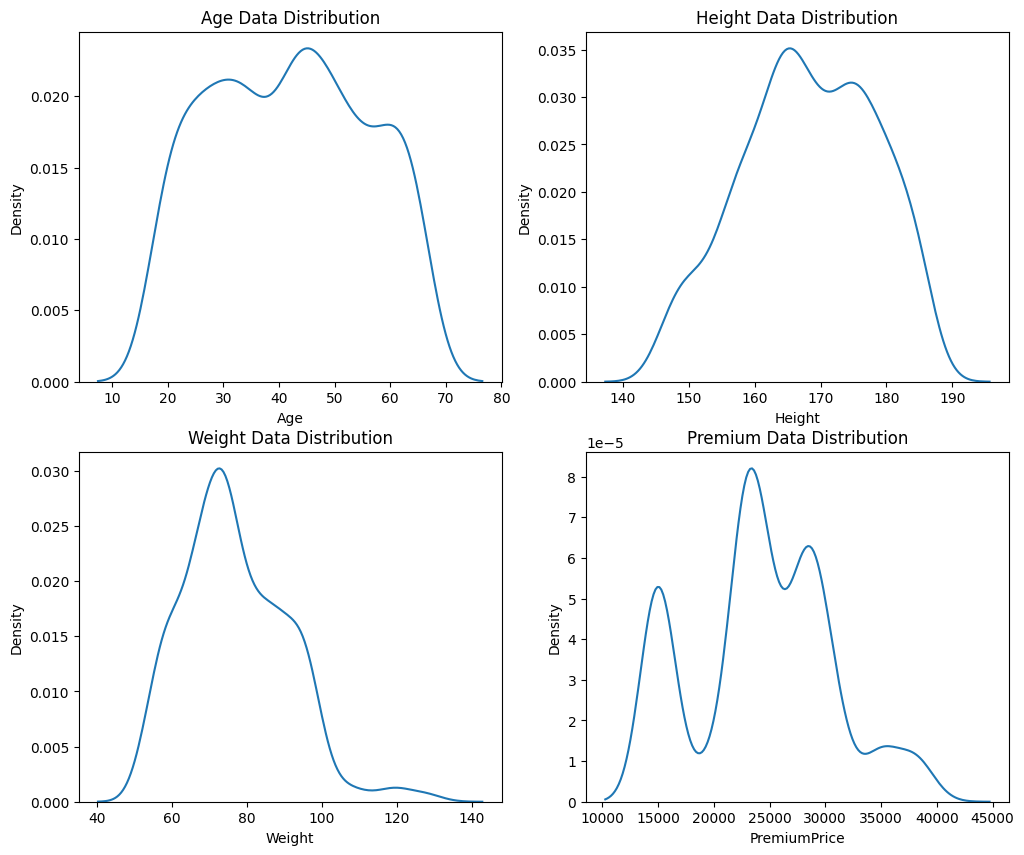

In [8]:
fig, axes=plt.subplots(2, 2, figsize=(12, 10))

def plot_data_distribution(data, x_var, coordinate, title):
    sns.kdeplot(data=data, x=x_var, ax=coordinate)
    coordinate.set_title(title)
plot_data_distribution(raw_ins_df,'Age',axes[0,0],'Age Data Distribution')
plot_data_distribution(raw_ins_df,'Height',axes[0,1],'Height Data Distribution')
plot_data_distribution(raw_ins_df,'Weight',axes[1,0],'Weight Data Distribution')
plot_data_distribution(raw_ins_df,'PremiumPrice',axes[1,1],'Premium Data Distribution')
plt.show()

As it can be seen from the above plots, except Premium Price other numerical distributions are appearing to be very close to gaussian distribution. The weight distribution is having a right skewness with few values beyond 115. 

In [9]:
raw_ins_df[raw_ins_df['Weight']>115]['Age'].count()

np.int64(19)

Out of 986 wieghts only 19 weights are above 115 which is around 2% of the overall data, which may not lead to serious impact in the analysis or model training. Also they are very close to the right extreme of the curve.

# Visualizations

In [10]:
def build_piechart_labels(df, group_by_col, agg_col, key_map):
    temp_df=df.groupby(group_by_col)[agg_col].count().reset_index()
    key_vals = key_map.keys()
    key_col = temp_df.columns[0]
    val_dict = {}
    for key in key_vals:
        val_dict[key_map[key]] = (temp_df[temp_df[key_col]==key].values[0])[1]
    return val_dict
    

In [11]:
diabetes_dict = build_piechart_labels(raw_ins_df,'Diabetes','Age',{0:'Non Diabetic',1:'Diabetic'})
bp_dict = build_piechart_labels(raw_ins_df,'BloodPressureProblems','Age',{0:'Normal',1:'High'})
transplants_dict = build_piechart_labels(raw_ins_df,'AnyTransplants','Age',{0:'No Transplants',1:'Transplants'})
chronic_dict = build_piechart_labels(raw_ins_df,'AnyChronicDiseases','Age',{0:'No Disease',1:'With Disease'})
allergies_dict = build_piechart_labels(raw_ins_df,'KnownAllergies','Age',{0:'No Allergy',1:'Allergy'})
cancer_dict = build_piechart_labels(raw_ins_df,'HistoryOfCancerInFamily','Age',{0:'No Cancer History',1:'Has Cancer History'})
surgery_dict = build_piechart_labels(raw_ins_df,'NumberOfMajorSurgeries','Age',{0:'No Surgery',1:'One Surgery',2:'Two Surgery',3:'Three Surgery'})

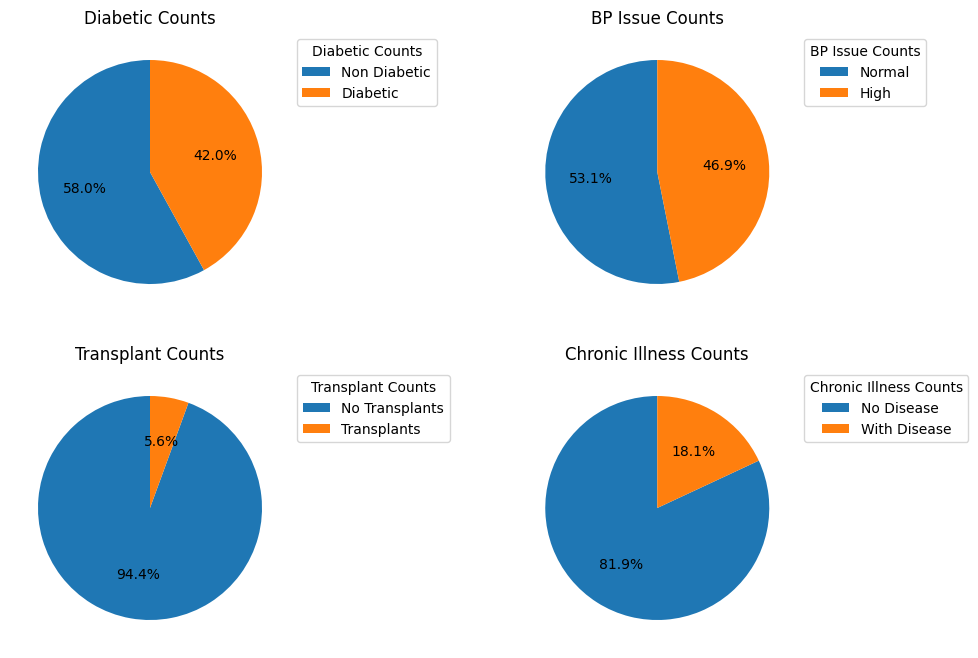

In [12]:
fig, axes=plt.subplots(2, 2, figsize=(12, 8))

def plot_data_distribution( labels,count_vals,  coordinate, title):
    wedges, texts, autotexts = coordinate.pie(count_vals,  autopct='%1.1f%%', startangle=90)
    coordinate.set_title(title)
    coordinate.legend(wedges, labels,
          title=title,
          loc="upper left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    


plot_data_distribution(diabetes_dict.keys(),diabetes_dict.values(),axes[0,0],'Diabetic Counts')
plot_data_distribution(bp_dict.keys(),bp_dict.values(),axes[0,1],'BP Issue Counts')
plot_data_distribution(transplants_dict.keys(),transplants_dict.values(),axes[1,0],'Transplant Counts')
plot_data_distribution(chronic_dict.keys(),chronic_dict.values(),axes[1,1],'Chronic Illness Counts')

plt.show()

There is a significant presense of Diabetic and Blood Pressure issue cases. There is a noticeable presense of Chronic Illness cases and negligible no. of Transplant cases.

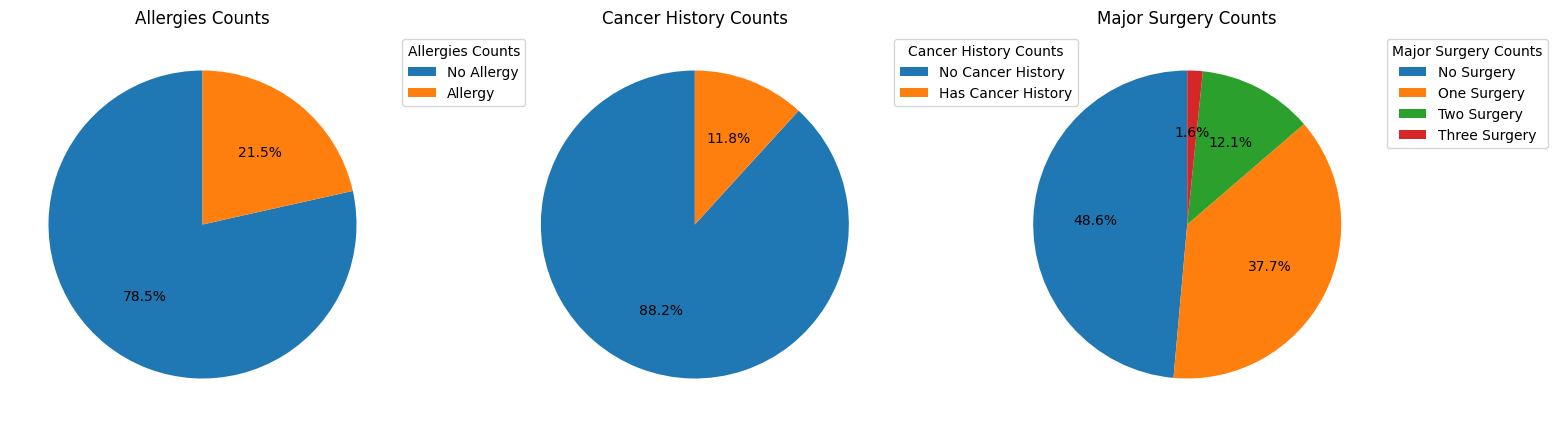

In [13]:
fig, axes=plt.subplots(1, 3, figsize=(18, 5))
plot_data_distribution(allergies_dict.keys(),allergies_dict.values(),axes[0],'Allergies Counts')
plot_data_distribution(cancer_dict.keys(),cancer_dict.values(),axes[1],'Cancer History Counts')
plot_data_distribution(surgery_dict.keys(),surgery_dict.values(),axes[2],'Major Surgery Counts')
plt.show()

There is noticeable presense of individuals having allergies and cancer history. There are significant number of individuals with 1 major surgery and a few of them are having 2 major surgeries. The number of individuals with 3 major surgeries are negligible.

## Feature Engineering

In [14]:
ins_df_bin = raw_ins_df.copy()

In [15]:
age_blocks = [0,20,30,40,50,60,100]
age_labels = [20,30,40,50,60,100]
ins_df_bin['Age_bin'] = pd.cut(ins_df_bin['Age'], bins=age_blocks, labels=age_labels, include_lowest=True)

In [16]:
ins_df_bin.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Age_bin
0,45,0,0,0,0,155,57,0,0,0,25000,50
1,60,1,0,0,0,180,73,0,0,0,29000,60
2,36,1,1,0,0,158,59,0,0,1,23000,40
3,52,1,1,0,1,183,93,0,0,2,28000,60
4,38,0,0,0,1,166,88,0,0,1,23000,40


In [17]:
ins_df_bin['BMI'] = round(ins_df_bin['Weight']/((ins_df_bin['Height']/100)**2),1)

In [18]:
ins_df_bin.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Age_bin,BMI
0,45,0,0,0,0,155,57,0,0,0,25000,50,23.7
1,60,1,0,0,0,180,73,0,0,0,29000,60,22.5
2,36,1,1,0,0,158,59,0,0,1,23000,40,23.6
3,52,1,1,0,1,183,93,0,0,2,28000,60,27.8
4,38,0,0,0,1,166,88,0,0,1,23000,40,31.9


In [19]:
bmi_bins = list(range(10,55,5))
bmi_labels = bmi_bins[1:]
ins_df_bin['BMI_BINS'] = pd.cut(ins_df_bin['BMI'], bins=bmi_bins,labels= bmi_labels, include_lowest=True)

In [20]:
ins_df_bin.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,Age_bin,BMI,BMI_BINS
0,45,0,0,0,0,155,57,0,0,0,25000,50,23.7,25
1,60,1,0,0,0,180,73,0,0,0,29000,60,22.5,25
2,36,1,1,0,0,158,59,0,0,1,23000,40,23.6,25
3,52,1,1,0,1,183,93,0,0,2,28000,60,27.8,30
4,38,0,0,0,1,166,88,0,0,1,23000,40,31.9,35


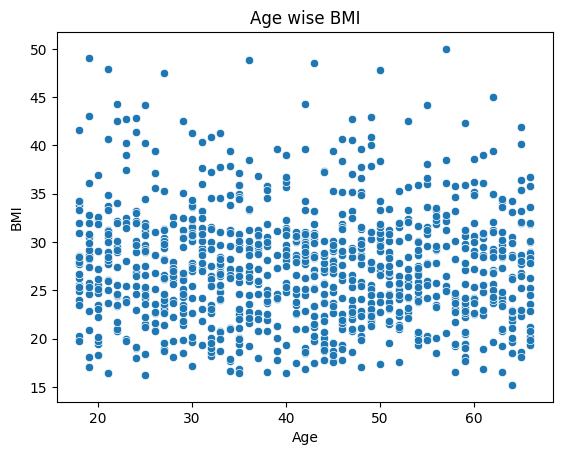

In [21]:
ax=sns.scatterplot(data=ins_df_bin, x='Age', y='BMI')
ax.set_title('Age wise BMI')
plt.show()

Majority of the individuals are having BMI between 20-35 across the age.

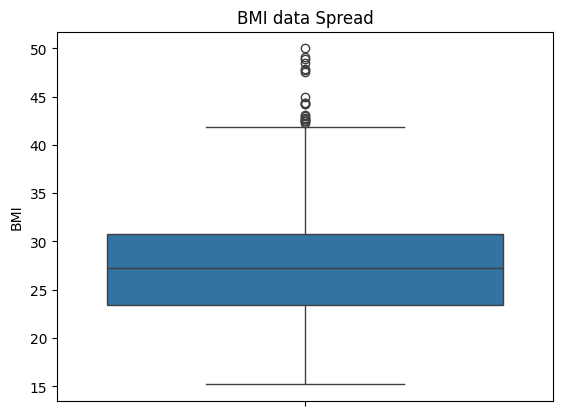

In [22]:
ax=sns.boxplot(data=ins_df_bin, y='BMI')
ax.set_title('BMI data Spread')
plt.show()

BMI is also having outliers primarily becuase of the weights distribution

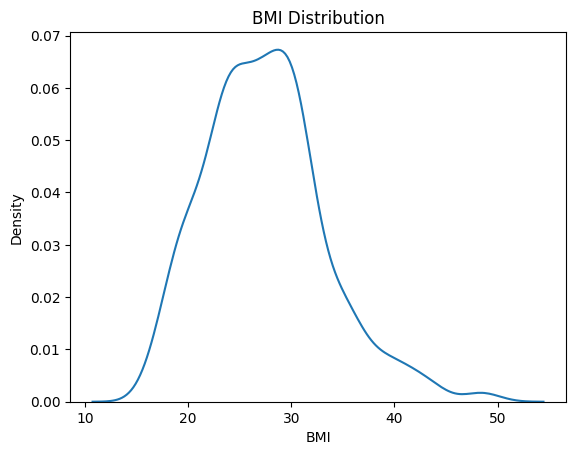

In [23]:
ax=sns.kdeplot(data=ins_df_bin, x='BMI')
ax.set_title('BMI Distribution')
plt.show()

BMI is following a normal distribution with a little bit of right skewness

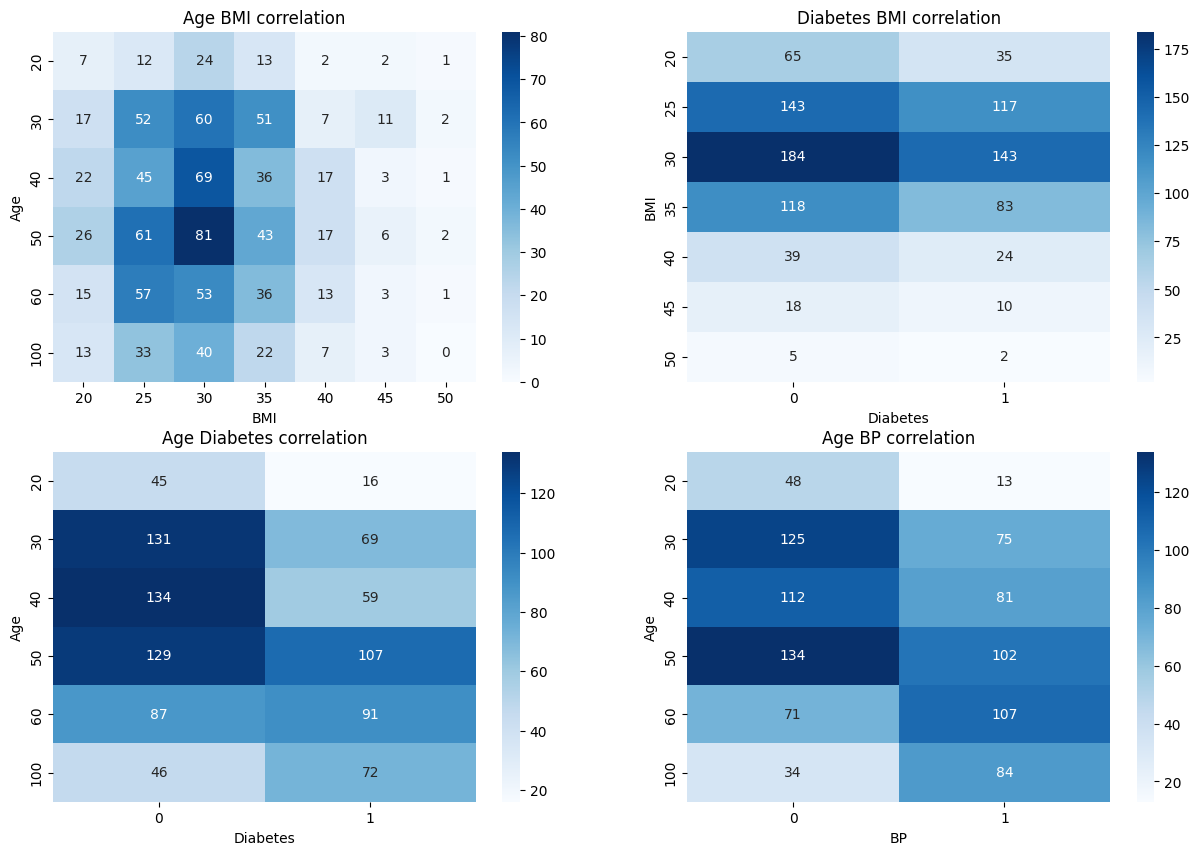

In [24]:
def plot_heat_maps(cat1_vals, cat2_vals, coordinate, title, x_label, y_label):
    contigency_table = pd.crosstab(cat1_vals,cat2_vals)
    sns.heatmap(contigency_table, annot=True, fmt="d", cmap="Blues", ax=coordinate)
    coordinate.set_title(title)
    coordinate.set_xlabel(x_label)
    coordinate.set_ylabel(y_label)
fig, axes=plt.subplots(2, 2, figsize=(15, 10))
plot_heat_maps(ins_df_bin['Age_bin'],ins_df_bin['BMI_BINS'], axes[0,0], 'Age BMI correlation','BMI','Age')
plot_heat_maps(ins_df_bin['BMI_BINS'],ins_df_bin['Diabetes'], axes[0,1], 'Diabetes BMI correlation','Diabetes','BMI')
plot_heat_maps(ins_df_bin['Age_bin'],ins_df_bin['Diabetes'], axes[1,0], 'Age Diabetes correlation','Diabetes','Age')
plot_heat_maps(ins_df_bin['Age_bin'],ins_df_bin['BloodPressureProblems'], axes[1,1], 'Age BP correlation','BP','Age')

Age vs BMI

Generally the BMI lies between 25-35 across all age groups


BMI vs Diabetes

Mostly Diabetes have a BMI between 25-40


Age Diabetes correlation

Mostly higher age groups are prone to diabetes


Age Bp correlation

Mostly higher age groups are prone to Blood pressure issues

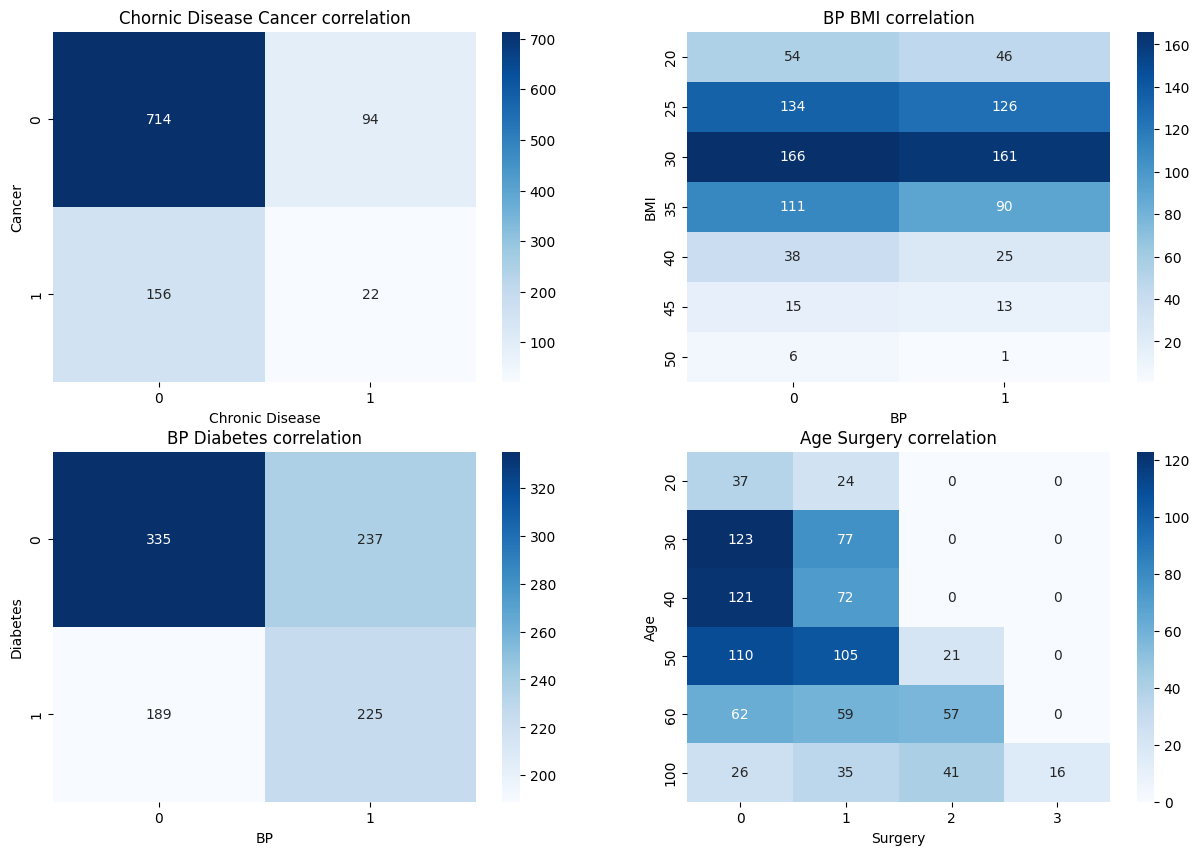

In [25]:
fig, axes=plt.subplots(2, 2, figsize=(15,10))
plot_heat_maps(ins_df_bin['AnyChronicDiseases'],ins_df_bin['HistoryOfCancerInFamily'], axes[0,0], 'Chornic Disease Cancer correlation','Chronic Disease','Cancer')
plot_heat_maps(ins_df_bin['BMI_BINS'],ins_df_bin['BloodPressureProblems'], axes[0,1], 'BP BMI correlation','BP','BMI')
plot_heat_maps(ins_df_bin['Diabetes'],ins_df_bin['BloodPressureProblems'], axes[1,0], 'BP Diabetes correlation','BP','Diabetes')
plot_heat_maps(ins_df_bin['Age_bin'],ins_df_bin['NumberOfMajorSurgeries'], axes[1,1], 'Age Surgery correlation','Surgery','Age')

Only 22/986 individuals are having cancer history with chronic disease

Only 225/986 people are having both diabetes and blood pressure issues

Most of the people having blood pressure issues have a BMI from 25-45

The higher is the age, the more is the probability of having more number of major surgeries

In [26]:
premium_age_bydiabetes=ins_df_bin.groupby(['Diabetes','Age_bin'])['PremiumPrice'].mean().reset_index()
premium_age_bybp=ins_df_bin.groupby(['BloodPressureProblems','Age_bin'])['PremiumPrice'].mean().reset_index()
premium_age_bytransplant=ins_df_bin.groupby(['AnyTransplants','Age_bin'])['PremiumPrice'].mean().reset_index()
premium_age_byChronic=ins_df_bin.groupby(['AnyChronicDiseases','Age_bin'])['PremiumPrice'].mean().reset_index()
premium_age_byAllergies=ins_df_bin.groupby(['KnownAllergies','Age_bin'])['PremiumPrice'].mean().reset_index()
premium_age_byCancer=ins_df_bin.groupby(['HistoryOfCancerInFamily','Age_bin'])['PremiumPrice'].mean().reset_index()

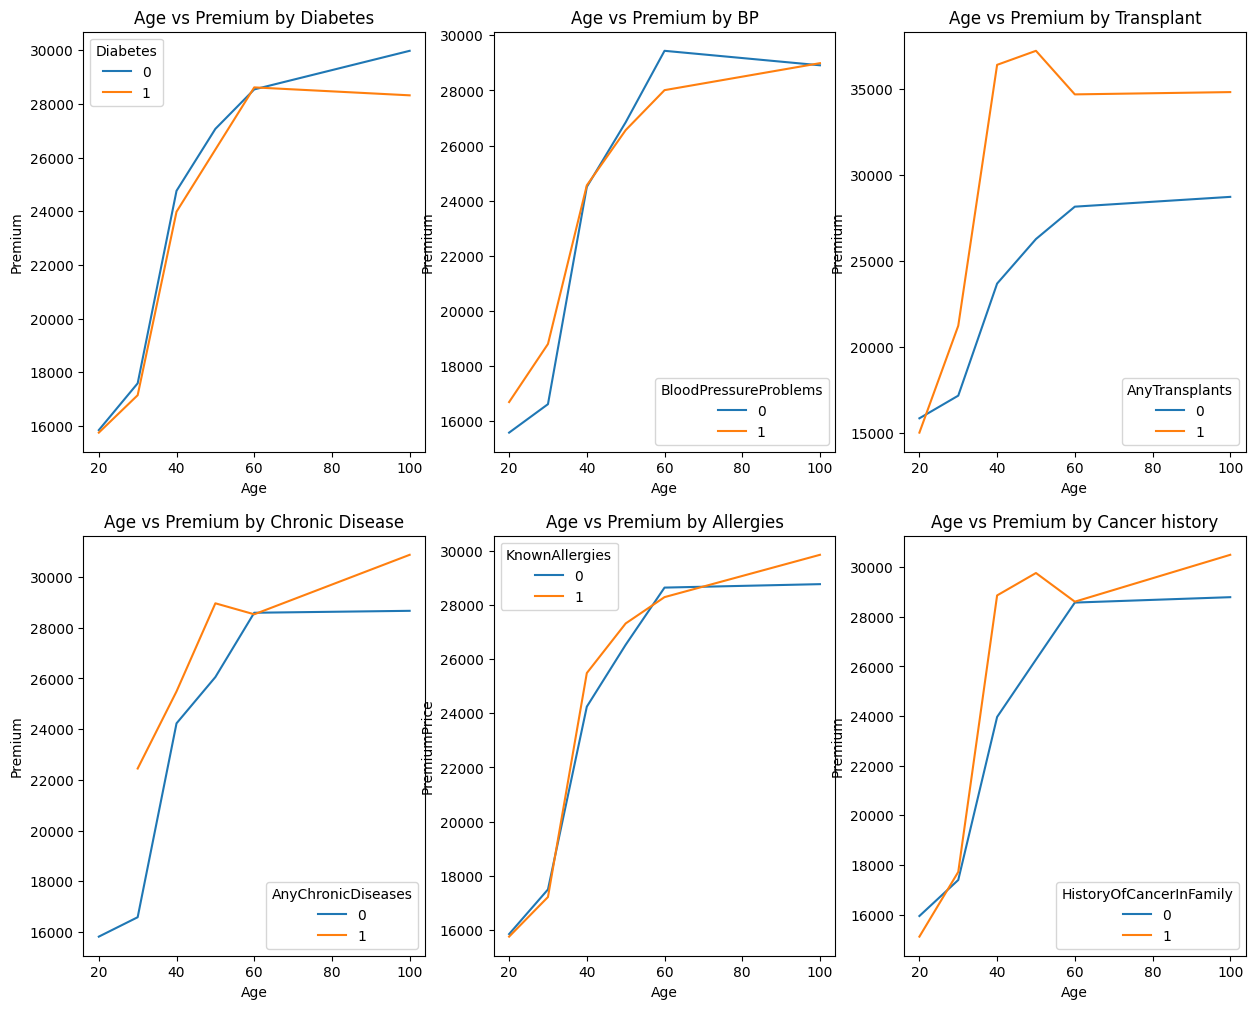

In [27]:
fig, axes=plt.subplots(2, 3, figsize=(15, 12))
sns.lineplot(data=premium_age_bydiabetes, x='Age_bin', y='PremiumPrice', hue='Diabetes', ax=axes[0,0])
axes[0,0].set_title('Age vs Premium by Diabetes')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Premium')
sns.lineplot(data=premium_age_bybp, x='Age_bin', y='PremiumPrice', hue='BloodPressureProblems', ax=axes[0,1])
axes[0,1].set_title('Age vs Premium by BP')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Premium')
sns.lineplot(data=premium_age_bytransplant, x='Age_bin', y='PremiumPrice', hue='AnyTransplants', ax=axes[0,2])
axes[0,2].set_title('Age vs Premium by Transplant')
axes[0,2].set_xlabel('Age')
axes[0,2].set_ylabel('Premium')
sns.lineplot(data=premium_age_byChronic, x='Age_bin', y='PremiumPrice', hue='AnyChronicDiseases', ax=axes[1,0])
axes[1,0].set_title('Age vs Premium by Chronic Disease')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Premium')
sns.lineplot(data=premium_age_byAllergies, x='Age_bin', y='PremiumPrice', hue='KnownAllergies', ax=axes[1,1])
axes[1,1].set_title('Age vs Premium by Allergies')
axes[1,1].set_xlabel('Age')
axes[1,2].set_ylabel('Premium')
sns.lineplot(data=premium_age_byCancer, x='Age_bin', y='PremiumPrice', hue='HistoryOfCancerInFamily', ax=axes[1,2])
axes[1,2].set_title('Age vs Premium by Cancer history')
axes[1,2].set_xlabel('Age')
axes[1,2].set_ylabel('Premium')
plt.show()

Primarily the transplants and presense of cancer history are showing as the major cause for premium inflation.

In [28]:
ins_df_bin.groupby('NumberOfMajorSurgeries')['Age'].count()

NumberOfMajorSurgeries
0    479
1    372
2    119
3     16
Name: Age, dtype: int64

In [29]:
round(ins_df_bin.groupby('NumberOfMajorSurgeries')['PremiumPrice'].mean(),2)

NumberOfMajorSurgeries
0    22968.68
1    24741.94
2    28084.03
3    28000.00
Name: PremiumPrice, dtype: float64

The average premium spikes up from 1 major to 2 major surgeries

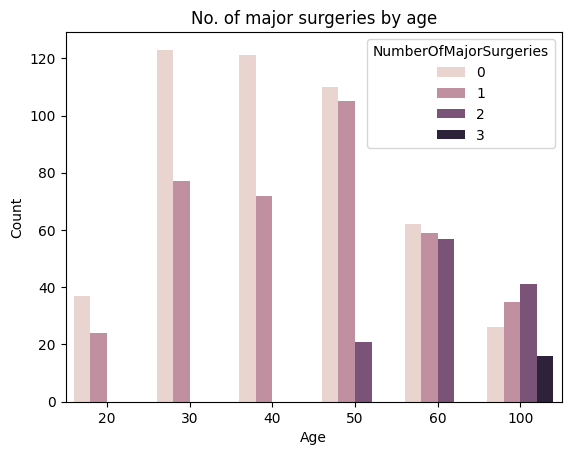

In [30]:
ax=sns.countplot(data=ins_df_bin, x='Age_bin', hue='NumberOfMajorSurgeries')
ax.set_title('No. of major surgeries by age')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

Mostly individuals who are above 30 are having atleast 1 major surgery. As the age increase there is higher probability that the individual has undergone more number of major surgeries.

In [31]:
premium_age_bysurgery=ins_df_bin.groupby(['NumberOfMajorSurgeries','Age_bin'])['PremiumPrice'].mean().reset_index()

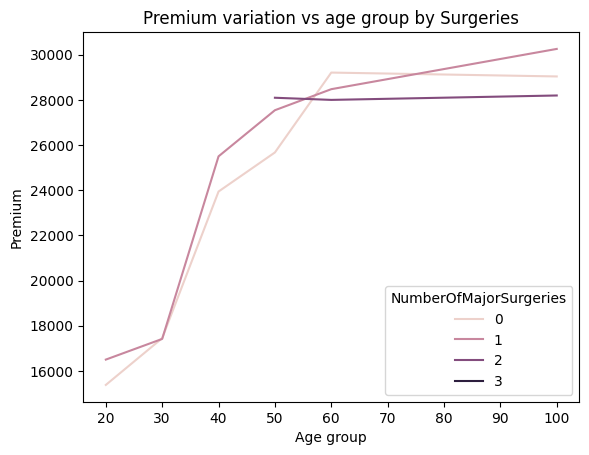

In [32]:
ax=sns.lineplot(data=premium_age_bysurgery, x='Age_bin', y='PremiumPrice', hue='NumberOfMajorSurgeries')
ax.set_title('Premium variation vs age group by Surgeries')
ax.set_xlabel('Age group')
ax.set_ylabel('Premium')
plt.show()

Premium spikes up significantly as the no. of surgeries increase.

In [33]:
premiums_by_bmi=ins_df_bin.groupby('BMI_BINS')['PremiumPrice'].mean().reset_index()
premiums_by_bmi['PremiumPrice'].fillna(0,inplace=True)
premiums_by_bmi['PremiumPrice'] = round(premiums_by_bmi['PremiumPrice'],2)

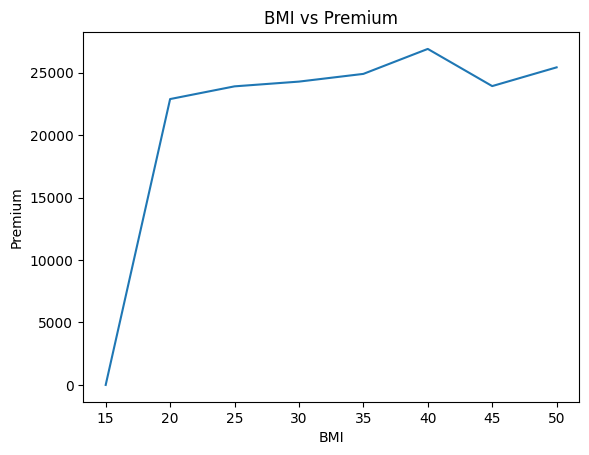

In [34]:
ax=sns.lineplot(data=premiums_by_bmi, x='BMI_BINS', y='PremiumPrice')
ax.set_title('BMI vs Premium')
ax.set_xlabel('BMI')
ax.set_ylabel('Premium')
plt.show()

There is no significant variation in premium with respect to BMI for BMI above 20

# Hypothesis Testing

## Impact of Health Conditions on Premium

In [35]:
def test_hypothesis_on_factors(df, factor,factor_label,premium_col_name='PremiumPrice'):
    negative_cases = ins_df_bin[ins_df_bin[factor]==0]['PremiumPrice']
    positive_cases = ins_df_bin[ins_df_bin[factor]==1]['PremiumPrice']
    if len(negative_cases)>30 and len(positive_cases)>30:
        tstat, pvalue=ztest(negative_cases,positive_cases,value=0, alternative='smaller')
        if pvalue<0.05:
            print(f'Reject null hypothesis. Premiums of negatives cases of {factor_label} are lower than positive cases')
        else:
            print(f'Failed to reject null hypothesis. {factor_label} has no impact on premiums')
    else:
        tstat, pvalue=ttest_ind(negative_cases,positive_cases, alternative='smaller')
        if pvalue<0.05:
            print(f'Reject null hypothesis. Premiums of negatives cases of {factor_label} are lower than positive cases')
        else:
            print(f'Failed to reject null hypothesis. {factor_label} has no impact on premiums')
        

In [36]:
binary_factors ={
    'Diabetes':'Diabetes',
    'BloodPressureProblems':'BP',
    'AnyTransplants':'Transplants',
    'AnyChronicDiseases':'Chronic Diseases',
    'KnownAllergies':'Allergy',
    'HistoryOfCancerInFamily':'Family Cancer History'
}

for factor in binary_factors.keys():
    test_hypothesis_on_factors(ins_df_bin,factor,binary_factors[factor])
        

Reject null hypothesis. Premiums of negatives cases of Diabetes are lower than positive cases
Reject null hypothesis. Premiums of negatives cases of BP are lower than positive cases
Reject null hypothesis. Premiums of negatives cases of Transplants are lower than positive cases
Reject null hypothesis. Premiums of negatives cases of Chronic Diseases are lower than positive cases
Failed to reject null hypothesis. Allergy has no impact on premiums
Reject null hypothesis. Premiums of negatives cases of Family Cancer History are lower than positive cases


In [37]:
no_surgery_premiums = ins_df_bin[ins_df_bin['NumberOfMajorSurgeries']==0]['PremiumPrice']
one_surgery_premiums = ins_df_bin[ins_df_bin['NumberOfMajorSurgeries']==1]['PremiumPrice']
two_surgery_premiums = ins_df_bin[ins_df_bin['NumberOfMajorSurgeries']==2]['PremiumPrice']
three_surgery_premiums = ins_df_bin[ins_df_bin['NumberOfMajorSurgeries']==3]['PremiumPrice']

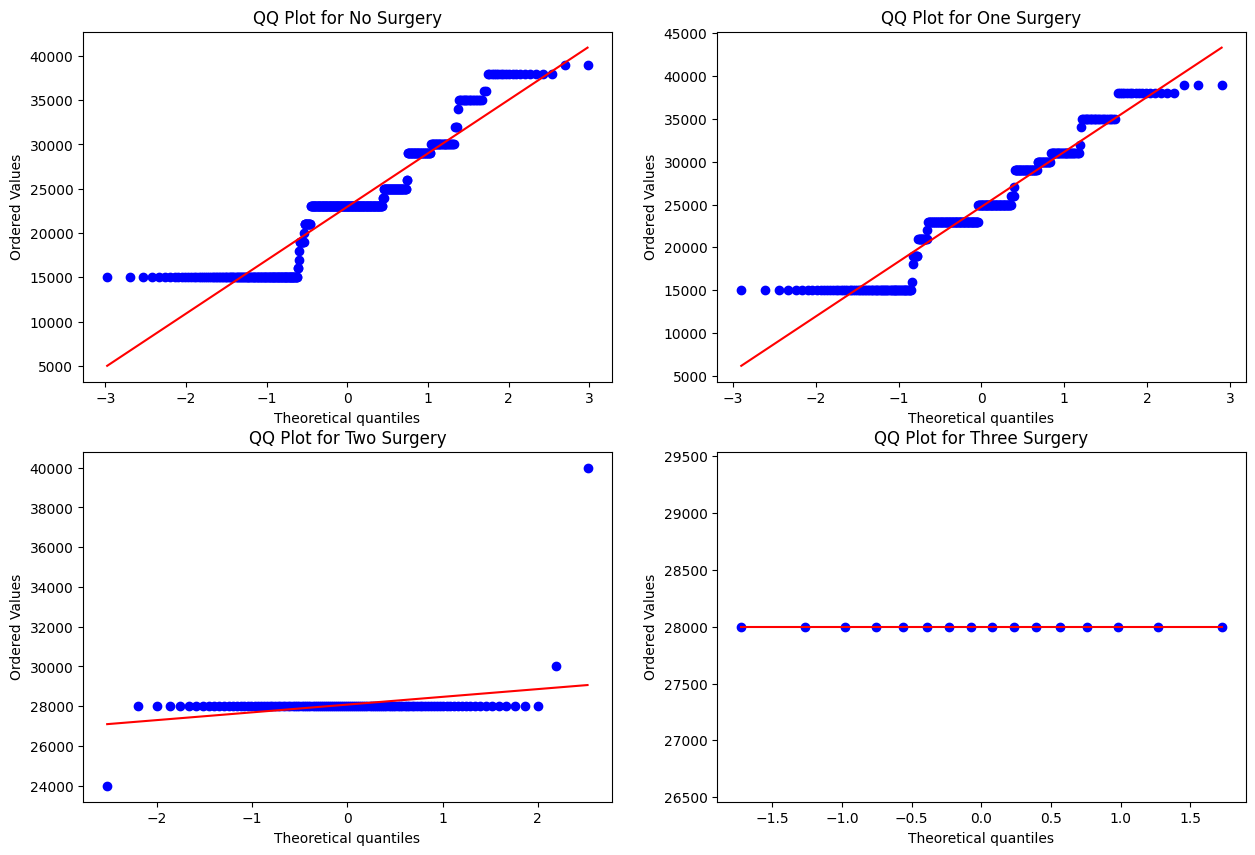

In [38]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
stats1.probplot(no_surgery_premiums, dist="norm", plot=plt)
plt.title('QQ Plot for No Surgery')
plt.subplot(2, 2, 2)
stats1.probplot(one_surgery_premiums, dist="norm", plot=plt)
plt.title('QQ Plot for One Surgery')
plt.subplot(2, 2, 3)
stats1.probplot(two_surgery_premiums, dist="norm", plot=plt)
plt.title('QQ Plot for Two Surgery')
plt.subplot(2, 2, 4)
stats1.probplot(three_surgery_premiums, dist="norm", plot=plt)
plt.title('QQ Plot for Three Surgery')
plt.show()

Most of the distributions are not normal distributions.

In [39]:
surgery_samples = {
    'no_surgery':no_surgery_premiums,
    'one_surgery':one_surgery_premiums,
    'two_surgery':two_surgery_premiums,
    'three_surgery':three_surgery_premiums
}
for surgery_count in surgery_samples.keys():
    p_val = shapiro(surgery_samples[surgery_count]).pvalue
    print(f'P-Value for {surgery_count} is {p_val}')
    if p_val>0.05 :
        print(f'{surgery_count} premiums have normal distribution')
    else:
        print(f"{surgery_count} premiums don't have normal distribution")
    


P-Value for no_surgery is 3.901965395277343e-18
no_surgery premiums don't have normal distribution
P-Value for one_surgery is 4.194464670933881e-12
one_surgery premiums don't have normal distribution
P-Value for two_surgery is 1.8090482740166476e-23
two_surgery premiums don't have normal distribution
P-Value for three_surgery is 1.0
three_surgery premiums have normal distribution


In [40]:
stat, pvalue = kruskal(no_surgery_premiums, one_surgery_premiums,two_surgery_premiums,three_surgery_premiums )
print(f'P Value is {pvalue}')
if pvalue<0.05:
    print('Reject null hypothesis. Major surgery does have an impact on premiums')
else:
    print("Failed to reject null hypothesis. Major surgeries don't have an impact on premiums")

P Value is 3.3223412749827346e-20
Reject null hypothesis. Major surgery does have an impact on premiums


In [41]:
chronic_cancer_contingency = pd.crosstab(ins_df_bin['AnyChronicDiseases'],ins_df_bin['HistoryOfCancerInFamily'])

In [42]:
pvalue=chi2_contingency(chronic_cancer_contingency).pvalue
print(f'P-Value: {pvalue}')
if pvalue>0.05:
    print('Failed to reject null hypothesis. Cancer History and Chronic Diseases are not correlated')
else:
    print('Reject null hypothesis. Cancer History and Chronic Diseases are correlated')

P-Value: 0.8858081638149811
Failed to reject null hypothesis. Cancer History and Chronic Diseases are not correlated


# EDA Conclusion

## Inferences

1. Major surgeries and Transplants are the key factors which spikes up the premium cost
2. Apart from Allergy all other factors like Diabetes, Blood Pressure Issues, Chronic diseases etc. does add up to premium inflation
3. Presense of chronic diseases doesn't mean that the individual is prone to cancer
4. BMI doesn't have any major say in premium variation
5. There is a higher probability of an individual in higher age group having undergone a major surgery

## Recommendations

1. Diabetes and Blodd Pressure issues are life style diseases which are mostly correctable by simple life style changes. Even though the individual is charged with inflated premium due to these, they can be offered concessions in future premiums if they they show positive changes in their medical reports suggesting incorporation of life style changes.
2. If someone has a history of cancer in their family, they can be offered Cancer treatment riders
3. Individuals with higher age group should be investigated for major surgeries
4. Individuals with chronic illness and transplants can be offered frequent hospitalization riders

# Model Training

## Data Preprocessing

In [43]:
ins_df_bin.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice',
       'Age_bin', 'BMI', 'BMI_BINS'],
      dtype='object')

In [44]:
cat_cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases','KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
num_cols = ['Age', 'BMI' ]
target_col = 'PremiumPrice'

As height and weight are already incorporated in BMI, there is no need to use them as features

In [45]:
input_cols = cat_cols + num_cols

In [46]:
X = ins_df_bin[input_cols]
Y = ins_df_bin[target_col]

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=1)

In [48]:
standardScaler = StandardScaler()
x_train_scaled = pd.DataFrame(standardScaler.fit_transform(x_train[num_cols]),index = x_train.index, columns = num_cols)
x_test_scaled = pd.DataFrame(standardScaler.fit_transform(x_test[num_cols]),index = x_test.index, columns = num_cols)

The numerical columns are scaled using standard scaler

In [49]:
def onehotencode_cat_cols(src_df, tgt_df, cat_col_name, prefix=None):
    cat_col_unique_vals = src_df[cat_col_name].unique()
    
    for cat_col_val in cat_col_unique_vals:
        encoded_col_name = f'{cat_col_name}_{cat_col_val}' if prefix is None else f'{prefix}_{cat_col_val}'
        tgt_df[encoded_col_name] = src_df[cat_col_name].apply(lambda x: 1.0 if x==cat_col_val else 0.0)

In [50]:
x_train_encoded = x_train_scaled.copy()
x_test_encoded = x_test_scaled.copy()
for cat_col in cat_cols:
    onehotencode_cat_cols(x_train,x_train_encoded,cat_col)
    onehotencode_cat_cols(x_test,x_test_encoded,cat_col)

The categorical columns are one hot encoded

### Utility functions for Model Performance assessment

In [51]:
def calculate_model_performance(y_true, y_pred, datapoints, feature_count):
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = (1 - ((1-r2)*(datapoints-1))/(datapoints-feature_count-1) )
    return (mae, mse, r2, adj_r2)
    

In [52]:
def print_model_performance(mae, mse, r2, adj_r2):
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2 Score: {r2}')
    print(f'Adjusted R2 Score: {adj_r2}')

In [53]:
def calculate_and_print_model_performance(y_true, y_pred, datapoints, feature_count):
    mae, mse, r2, adj_r2=calculate_model_performance(y_true, y_pred, datapoints, feature_count)
    print_model_performance(mae, mse, r2, adj_r2)

In [54]:
train_datapoints=x_train_encoded.shape[0]
train_feature_count=x_train_encoded.shape[1]
test_datapoints=x_test_encoded.shape[0]
test_feature_count=x_test_encoded.shape[1]

In [55]:
def print_feature_importances(feature_names, coefficients):
    for f_name, coe in zip(feature_names, coefficients):
        print(f'Feature: {f_name}, Importance : {coe}')

## Linear Regression Model Training

In [56]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(x_train_encoded, y_train)
y_train_pred = linear_reg_model.predict(x_train_encoded)

In [57]:
calculate_and_print_model_performance(y_train,y_train_pred, train_datapoints, train_feature_count )

Mean Absolute Error: 2652.40109462891
Mean Squared Error: 13561990.379356626
R2 Score: 0.6472175709905275
Adjusted R2 Score: 0.6389599848758714


The R2 score is 65% on training data

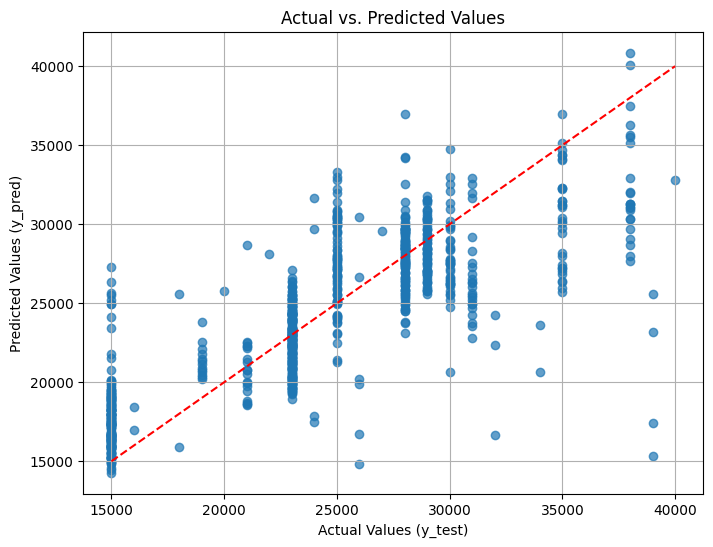

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7) # Scatter plot of actual vs. predicted
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--') # Ideal 45-degree line
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs. Predicted Values")
plt.grid(True)
plt.show()

In [59]:
print_feature_importances(x_train_encoded.columns, linear_reg_model.coef_)

Feature: Age, Importance : 4730.000830266184
Feature: BMI, Importance : 777.3038469853284
Feature: Diabetes_1, Importance : -222.4659582275315
Feature: Diabetes_0, Importance : 222.46595822753548
Feature: BloodPressureProblems_0, Importance : -95.60817951576881
Feature: BloodPressureProblems_1, Importance : 95.60817951577052
Feature: AnyTransplants_0, Importance : -3834.2879053135316
Feature: AnyTransplants_1, Importance : 3834.287905313533
Feature: AnyChronicDiseases_1, Importance : 1378.553575115159
Feature: AnyChronicDiseases_0, Importance : -1378.5535751151606
Feature: KnownAllergies_0, Importance : -59.482507472599806
Feature: KnownAllergies_1, Importance : 59.4825074725998
Feature: HistoryOfCancerInFamily_0, Importance : -771.44384018368
Feature: HistoryOfCancerInFamily_1, Importance : 771.4438401836796
Feature: NumberOfMajorSurgeries_0, Importance : 872.4298475097947
Feature: NumberOfMajorSurgeries_1, Importance : 1189.5249215926278
Feature: NumberOfMajorSurgeries_2, Importance 

In [60]:
l1_ratio_list = []
for i in range(1,10):
    l1_ratio_list.append(i/10)

In [61]:
mae_perf = []
mse_perf = []
r2_perf = []
adj_r2_perf = []

for l1_ratio_it in l1_ratio_list:
    elastic_net_reg_model = ElasticNet(l1_ratio = l1_ratio_it)
    elastic_net_reg_model.fit(x_train_encoded, y_train)
    y_train_pred = elastic_net_reg_model.predict(x_train_encoded)
    mae_it, mse_it, r2_it, adj_r2_it = calculate_model_performance(y_train, y_train_pred,train_datapoints, train_feature_count  )
    mae_perf.append(mae_it)
    mse_perf.append(mse_it)
    r2_perf.append(r2_it)
    adj_r2_perf.append(adj_r2_it)

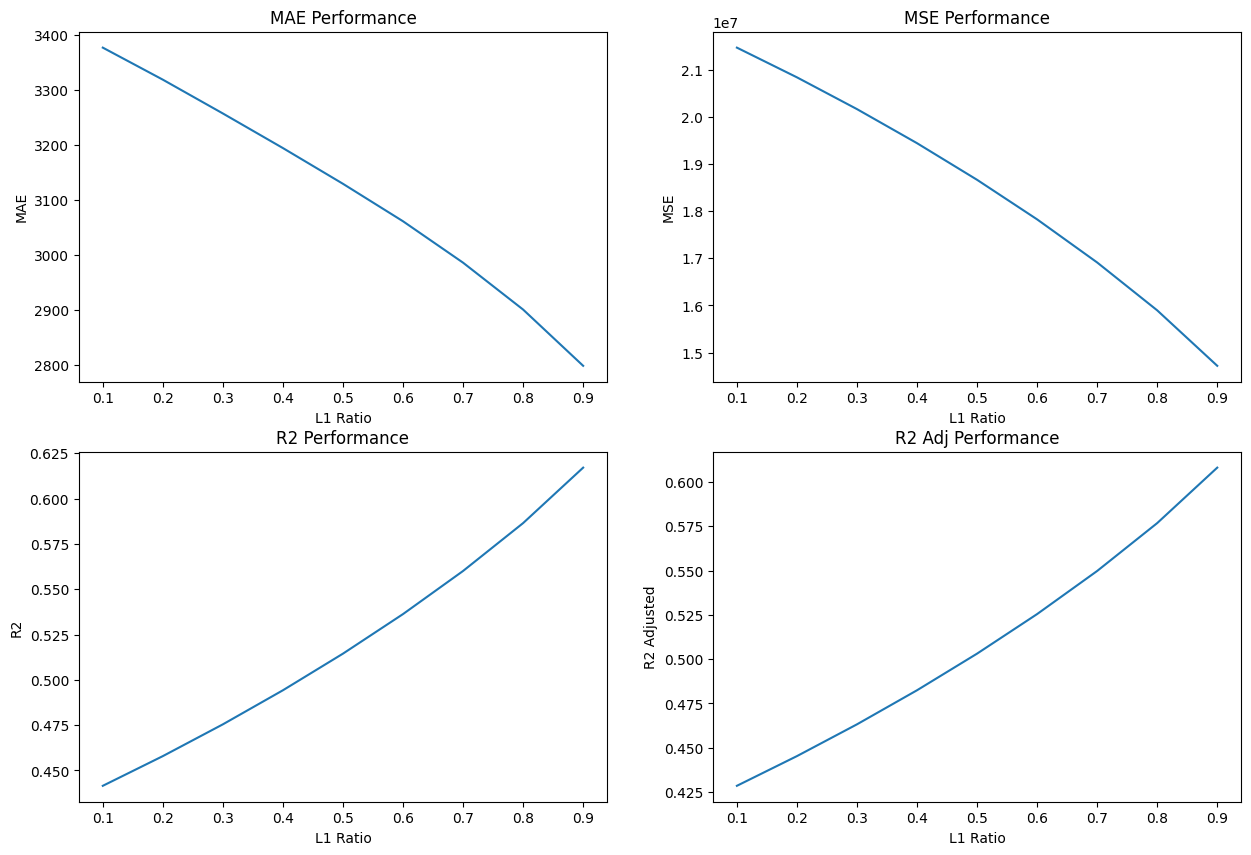

In [62]:
fig, axes=plt.subplots(2, 2, figsize=(15, 10))
sns.lineplot(x=l1_ratio_list, y=mae_perf, ax = axes[0,0])
axes[0,0].set_title('MAE Performance')
axes[0,0].set_xlabel('L1 Ratio')
axes[0,0].set_ylabel('MAE')
sns.lineplot(x=l1_ratio_list, y=mse_perf, ax = axes[0,1])
axes[0,1].set_title('MSE Performance')
axes[0,1].set_xlabel('L1 Ratio')
axes[0,1].set_ylabel('MSE')
sns.lineplot(x=l1_ratio_list, y=r2_perf, ax = axes[1,0])
axes[1,0].set_title('R2 Performance')
axes[1,0].set_xlabel('L1 Ratio')
axes[1,0].set_ylabel('R2')
sns.lineplot(x=l1_ratio_list, y=adj_r2_perf, ax = axes[1,1])
axes[1,1].set_title('R2 Adj Performance')
axes[1,1].set_xlabel('L1 Ratio')
axes[1,1].set_ylabel('R2 Adjusted')
plt.show()

0.9 L1 ratio is having the best performance from all performance matrix

In [63]:
elastic_net_reg_model = ElasticNet(l1_ratio = 0.9)
elastic_net_reg_model.fit(x_train_encoded, y_train)

,alpha,1.0
,l1_ratio,0.9
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


## Train Random Forest Regressor

In [64]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [ 10, 20, 50],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 5]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(x_train_encoded, y_train)

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [65]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 200}


In [66]:
randomForestRegressor = RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=7, n_estimators=300)

In [67]:
randomForestRegressor.fit(x_train_encoded, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,50
,min_samples_split,7
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
y_train_pred = randomForestRegressor.predict(x_train_encoded)

In [69]:
calculate_and_print_model_performance(y_train, y_train_pred,train_datapoints, train_feature_count  )

Mean Absolute Error: 949.7705801253782
Mean Squared Error: 3949321.108788208
R2 Score: 0.897267948529338
Adjusted R2 Score: 0.8948632971295045


The R2 score on training data is showing 92% accuracy

## Train Gradient Boosting Regressor

In [70]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(x_train_encoded, y_train)

,estimator,GradientBoostingRegressor()
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [71]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [72]:
grad_boost_reg_model = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=300)
grad_boost_reg_model.fit(x_train_encoded, y_train)

,loss,'squared_error'
,learning_rate,0.01
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [73]:
y_train_pred = grad_boost_reg_model.predict(x_train_encoded)

In [74]:
calculate_and_print_model_performance(y_train, y_train_pred,train_datapoints, train_feature_count  )

Mean Absolute Error: 1312.334265637838
Mean Squared Error: 4203430.253619012
R2 Score: 0.8906579127720952
Adjusted R2 Score: 0.8880985401191663


The R2 score on training data is showing almost 93% accuracy

## Train  XGBoost Regressor

In [75]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1)
grid_search.fit(x_train_encoded, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [76]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [77]:
xgb_reg_model = XGBRegressor(objective='reg:squarederror', random_state=42, learning_rate=0.01,max_depth=5, n_estimators=300 )

In [78]:
xgb_reg_model.fit(x_train_encoded, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [79]:
y_train_pred = xgb_reg_model.predict(x_train_encoded)

In [80]:
calculate_and_print_model_performance(y_train, y_train_pred,train_datapoints, train_feature_count  )

Mean Absolute Error: 1376.0718994140625
Mean Squared Error: 4993429.5
R2 Score: 0.8701080083847046
Adjusted R2 Score: 0.867067623665491


The R2 score on training data is showing 91% accuracy

## Model Performance Comparison

In [81]:
model_dict = {
    'linear':elastic_net_reg_model,
    'random_forest':randomForestRegressor,
    'gradient_boosting': grad_boost_reg_model,
    'xg_boost': xgb_reg_model
}

def build_perf_matrix(models, x_train, y_train, x_test, y_test):
    perf_dict= {
        'model_name':[],
        'dataset_type':[],
        'mae':[],
        'mse':[],
        'r2':[],
        'r2_adj':[]
    }
    for model_name in models.keys():
        reg_model = models[model_name]
        y_train_pred = reg_model.predict(x_train)
        mae_train, mse_train, r2_train, adj_r2_train = calculate_model_performance(y_train, y_train_pred,x_train.shape[0], x_train.shape[1]  )
        perf_dict['model_name'].append(model_name)
        perf_dict['dataset_type'].append('train')
        perf_dict['mae'].append(mae_train)
        perf_dict['mse'].append(mse_train)
        perf_dict['r2'].append(r2_train)
        perf_dict['r2_adj'].append(adj_r2_train)
        y_test_pred = reg_model.predict(x_test)
        mae_test, mse_test, r2_test, adj_r2_test = calculate_model_performance(y_test, y_test_pred,x_test.shape[0], x_test.shape[1]  )
        perf_dict['model_name'].append(model_name)
        perf_dict['dataset_type'].append('test')
        perf_dict['mae'].append(mae_test)
        perf_dict['mse'].append(mse_test)
        perf_dict['r2'].append(r2_test)
        perf_dict['r2_adj'].append(adj_r2_test)
    
    return pd.DataFrame(perf_dict)
        

In [82]:
perf_df = build_perf_matrix(model_dict, x_train_encoded,y_train, x_test_encoded[x_train_encoded.columns], y_test )

In [83]:
perf_df.head(10)

,model_name,dataset_type,mae,mse,r2,r2_adj
0,linear,train,2798.413852,1.472088e+07,0.617072,0.608109
1,linear,test,2903.260093,1.874265e+07,0.537614,0.491117
2,random_forest,train,949.770580,3.949321e+06,0.897268,0.894863
3,random_forest,test,2456.328675,2.300825e+07,0.432381,0.375302
4,gradient_boosting,train,1312.334266,4.203430e+06,0.890658,0.888099
5,gradient_boosting,test,2614.156000,2.481624e+07,0.387777,0.326213
6,xg_boost,train,1376.071899,4.993430e+06,0.870108,0.867068
7,xg_boost,test,2585.004639,2.416245e+07,0.403907,0.343964


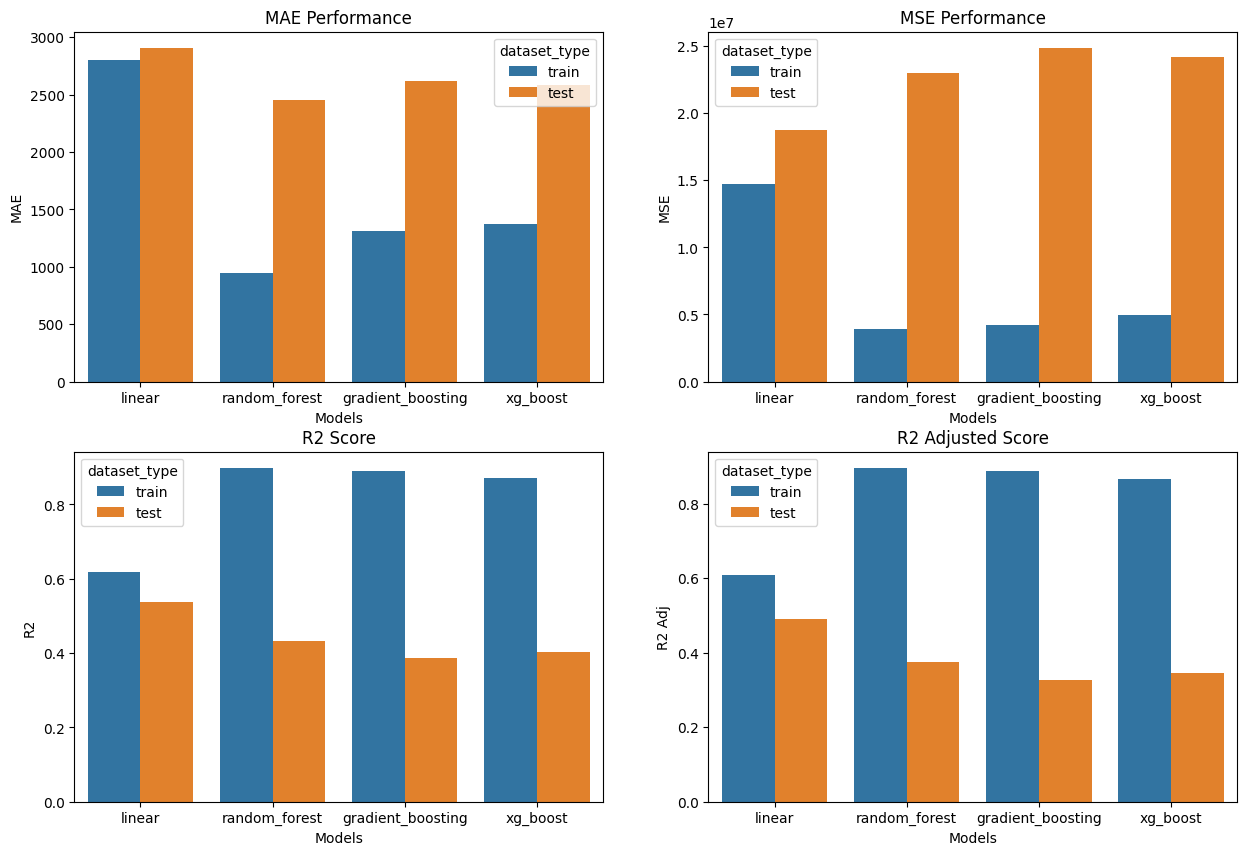

In [84]:
fig, axes=plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(data=perf_df, x='model_name', y='mae', hue='dataset_type', ax=axes[0,0])
axes[0,0].set_title('MAE Performance')
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('MAE')
sns.barplot(data=perf_df, x='model_name', y='mse', hue='dataset_type', ax=axes[0,1])
axes[0,1].set_title('MSE Performance')
axes[0,1].set_xlabel('Models')
axes[0,1].set_ylabel('MSE')
sns.barplot(data=perf_df, x='model_name', y='r2', hue='dataset_type', ax=axes[1,0])
axes[1,0].set_title('R2 Score')
axes[1,0].set_xlabel('Models')
axes[1,0].set_ylabel('R2')
sns.barplot(data=perf_df, x='model_name', y='r2_adj', hue='dataset_type', ax=axes[1,1])
axes[1,1].set_title('R2 Adjusted Score')
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('R2 Adj')
plt.show()

As seen from the bar plots above, all the models which use decision tree,i.e., Random Forest, GBDT and XGBOOST are showing very high performance with training data but extremely poor performance with testing data. This shows the decision tree based models are extremely overfitting the training data. Whereas the simple Linear Regression model with elastic net regularization is having a more uniform performance from all aspects across train and test dataset. So even though the training accuracy is lower than the decision tree models, the linear regression model can be trusted more on the unseen data.

Therefore, it is a more preferable candidate for model deployment

# Persist Trained Model and Standard Scaler

In [85]:
model_filename = 'linear_reg_model.pkl'
scaler_filename = 'std_scaler.pkl'
with open(model_filename, 'wb') as model_file:
        pickle.dump(elastic_net_reg_model, model_file)
with open(scaler_filename, 'wb') as scaler_file:
        pickle.dump(standardScaler, scaler_file)
